In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mysql import connector
from dotenv import load_dotenv
import os
import geopandas as gpd 

In [37]:
load_dotenv()
key = os.getenv("MYSQL_PASSWORD")
db = connector.connect(host="localhost", user="root", passwd=key, database="Artisan")

### 1) Life Expectancy for Continents

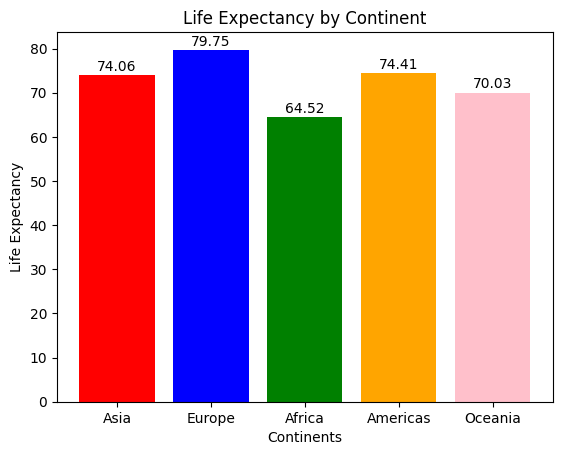

In [69]:
# Run cursor for aggregate operator
cursor_1 = db.cursor() 
cursor_1.execute("SELECT country.continent, AVG(life_expectancy.age) AS average_life_expectancy FROM life_expectancy INNER JOIN country ON life_expectancy.country_code = country.country_code GROUP BY country.continent;")

data = cursor_1.fetchall()
data.pop()

data_df = pd.DataFrame(data)

fig, ax = plt.subplots()
colors = ['red', 'blue', 'green', 'orange', 'pink']
ax.bar(data_df[0], data_df[1], color=colors)

# Set labels and title
ax.set_xlabel('Continents')
ax.set_ylabel('Life Expectancy')
ax.set_title('Life Expectancy by Continent')

# Put values on top of every column
for i, v in enumerate(data_df[1]):
    ax.text(i, v + 1, format(v, ".2f"), ha='center')

plt.show()


### 2) HIV Death Rates by Age

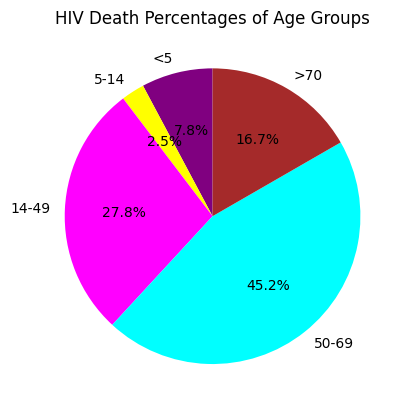

In [85]:
# Run cursor for SUM operators
cursor_2 = db.cursor() 
cursor_2.execute("SELECT SUM(death_rate_age_under_5) AS under_5, SUM(death_rate_age_5_14) AS age_5_14, SUM(death_rate_age_14_49) AS age_14_49, SUM(death_rate_age_50_69) AS age_50_69, SUM(death_rate_age_over_70) AS over_70 FROM HIV_deaths;")

data = cursor_2.fetchall()

labels = ["<5", "5-14", "14-49", "50-69", ">70"]
colors = ["purple", "yellow", "magenta", "cyan", "brown"]

fig, ax = plt.subplots()

# Plot the pie chart
ax.pie(data[0], labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Set title
ax.set_title("HIV Death Percentages of Age Groups")

# Display the chart
plt.show()


### 3) Deaths by Disease Type

In [166]:
# Run cursor for GROUP BY operator
cursor_3 = db.cursor() 
cursor_3.execute("SELECT disease_type, AVG(death_num) AS average_deaths, MAX(death_num) AS max_death_num FROM deaths GROUP BY disease_type ORDER BY AVG(death_num);")
data = cursor_3.fetchall()
data_df = pd.DataFrame(data, columns=["Disease Type", "Total Deaths", "Average Deaths per Country"])

In [167]:
data_df

,Disease Type,Total Deaths,Average Deaths per Country
0,meningitis,2809.1456,236222
1,HIV/AIDS,9634.3038,863837
2,Tuberculosis,14105.8101,1179766
3,cardiovascular,223185.0380,18562510


### 4) Life Expectancy vs Development Index

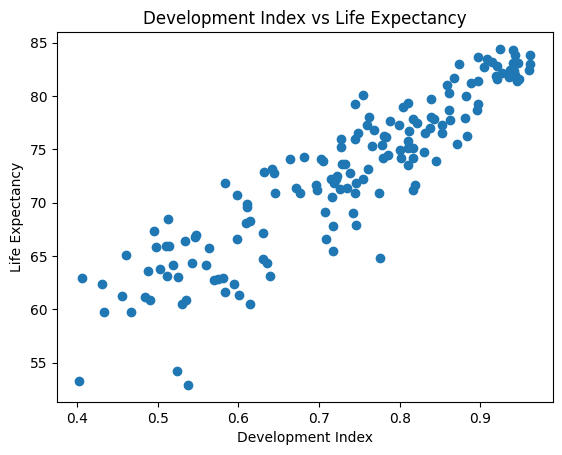

In [174]:
# Run cursor for INNER JOIN operator
cursor_4 = db.cursor() 
cursor_4.execute("Select development_index, age FROM country INNER JOIN life_expectancy ON country.country_code = life_expectancy.country_code")
data = cursor_4.fetchall()

data_df = pd.DataFrame(data)

x_values = data_df[0]
y_values = data_df[1]

# Create a scatter plot
# Each dot represents a country
plt.scatter(x_values, y_values)

# Set labels
plt.xlabel('Development Index')
plt.ylabel('Life Expectancy')
plt.title('Development Index vs Life Expectancy')

plt.show()

### 5) HIV Deaths / Population by Countries

/var/folders/p4/w5cgd6hs1tsd7tddgjp26yn80000gn/T/ipykernel_64205/1182059882.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


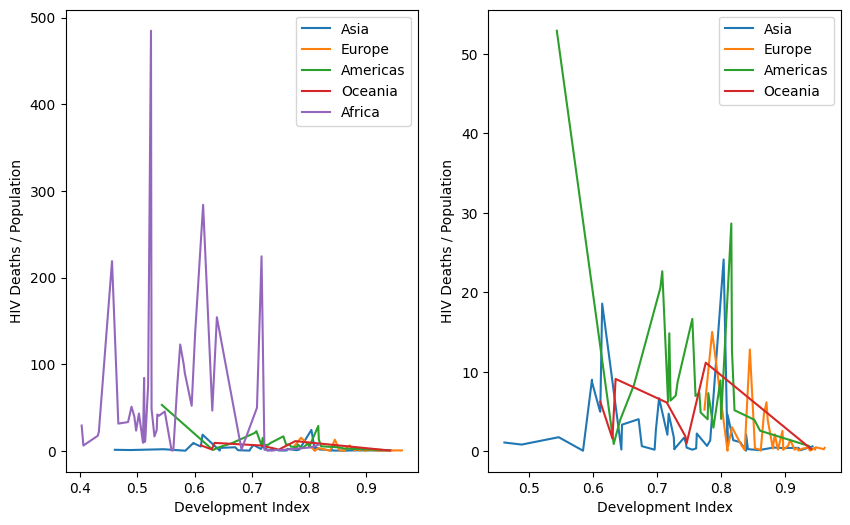

In [227]:
# Run cursor for INNER JOIN operator
cursor_5 = db.cursor() 
cursor_5.execute("Select development_index, population, death_num, continent FROM country INNER JOIN (SELECT * from deaths WHERE disease_type = 'HIV/AIDS') AS deaths_filtered ON country.country_code = deaths_filtered.country_code")
data = cursor_4.fetchall()

data_df = pd.DataFrame(data)
# Add ratio:
data_df[4] = ((data_df[2] / data_df[1]) * 100000).round(3)
data_df.sort_values(by=0, inplace=True)

data_df_asia = data_df[data_df[3] == "Asia"]
data_df_europe = data_df[data_df[3] == "Europe"]
data_df_africa = data_df[data_df[3] == "Africa"]
data_df_americas = data_df[data_df[3] == "Americas"]
data_df_oceania = data_df[data_df[3] == "Oceania"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.plot(data_df_asia[0], data_df_asia[4], label='Asia')
ax1.plot(data_df_europe[0], data_df_europe[4], label='Europe')
ax1.plot(data_df_americas[0], data_df_americas[4], label='Americas')
ax1.plot(data_df_oceania[0], data_df_oceania[4], label='Oceania')
ax1.plot(data_df_africa[0], data_df_africa[4], label='Africa')

ax2.plot(data_df_asia[0], data_df_asia[4], label='Asia')
ax2.plot(data_df_europe[0], data_df_europe[4], label='Europe')
ax2.plot(data_df_americas[0], data_df_americas[4], label='Americas')
ax2.plot(data_df_oceania[0], data_df_oceania[4], label='Oceania')

# Set labels
ax1.set(xlabel="Development Index", ylabel="HIV Deaths / Population")
ax2.set(xlabel="Development Index", ylabel="HIV Deaths / Population")

# Add legend
ax1.legend()
ax2.legend()

fig.show()

### 6) ART Cures by Counties

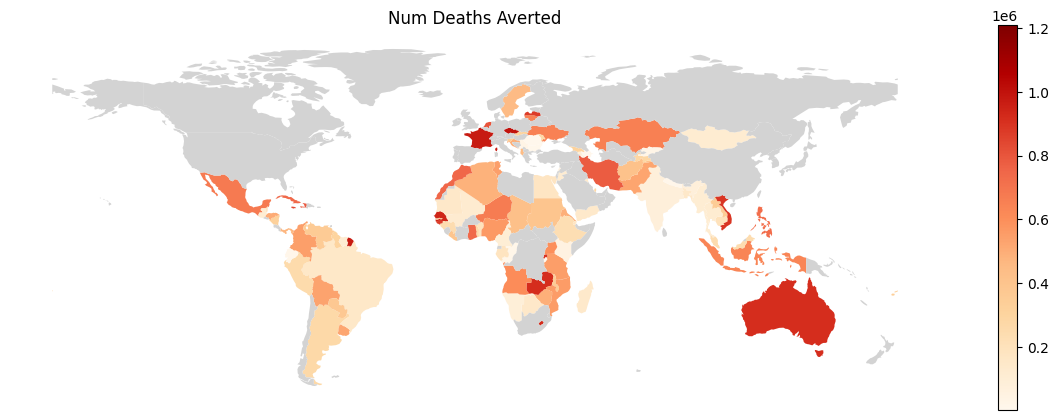

In [269]:
# world is a GeoDataFrame object
cursor_6 = db.cursor() 
cursor_6.execute("Select name, num_deaths_averted FROM country INNER JOIN cures_by_art ON country.country_code = cures_by_art.country_code")
data = cursor_4.fetchall()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]

data_df = pd.DataFrame(data)
data_df["name"] = data_df[0].copy()
data_df["num_deaths_averted"] = data_df[1].copy()

data_df.drop(columns=[0, 1], inplace=True)

data_world = world.copy().merge(data_df, on=["name"], how="outer")

ax = data_world.plot(column="num_deaths_averted", missing_kwds={"color": "lightgray"}, figsize=(15, 5), cmap="OrRd", legend=True)
ax.set_axis_off()
plt.title("Num Deaths Averted")
plt.show()